#  Intracranial Hemorrhage Detection

## Model 6

#### Kristina Joos

---   

|                 	|                                                        	|
|:----------------:	|:-------------------------------------------------------:	|
| Model           	| VGG 16 (242x242) Multiple Outputs Heads, Trainable=False  |
| Augementation    	| Crop, Affine, Flip                	                    |
| Windowing         | Single Window                                             |
| Class Balancing 	| Undersampling                                           	|
| Loss Function   	| Binary_crossentropy                                      	|
| Regularization  	| Early Stopping, Drop Out Layers 0.3 	                    |
| Epochs Run      	| 115                                                      	|
| Time Run (h)   	| 7                                                     	|
|                 	|                                                        	|
| Test           	| Accuracy: any 0.7053 subtype 0.2917 Loss: 0.5542         	|
| Validation      	| Accuracy: any 0.7028 subtype 0.4675 Loss: 0.5569        	|
| Leader Board    	| Score: 0.66256 Rank: 412/1345 (31%)                      	|



In [1]:
import numpy as np
import pandas as pd
import pydicom
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import collections
from tqdm import tqdm_notebook as tqdm
from datetime import datetime

from math import ceil, floor, log
import cv2

import tensorflow as tf

from tensorflow.keras import backend as K

import sys

from keras_applications.inception_v3 import InceptionV3




from skimage.transform import resize
from imgaug import augmenters as iaa
 
from sklearn.model_selection import train_test_split, StratifiedKFold, ShuffleSplit



from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet_50
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg_16

from tensorflow.keras.applications import ResNet50, VGG16, VGG19
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet_50
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg_16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Activation, concatenate, Dropout, MaxPooling2D, Conv2D, Flatten
from tensorflow.keras.initializers import glorot_normal, he_normal
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model, load_model, Sequential, load_model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

In [2]:
tf.test.is_gpu_available()

True

In [3]:
tf.test.is_built_with_cuda()

True

## Image Path

In [4]:
path_train_data = '../data/input/rsna-intracranial-hemorrhage-detection/stage_2_train/'

In [5]:
path_test_data = '../data/input/rsna-intracranial-hemorrhage-detection/stage_2_test/'

In [6]:
def get_number_of_files(path, data_name):
    no =  len(os.listdir(path))
    print (f'The {data_name} contains {no} files.')

In [7]:
def get_size_directory(path, data_name):
    size = round(sum([os.path.getsize(f'{path}'+ f'{file}') for file in os.listdir(path)])*(10**-9), 2)
    print (f'The size of the {data_name} is {size} GB.')

In [8]:
print('***TRAIN DATA***')
get_size_directory(path_train_data, 'Training Data')
get_number_of_files(path_train_data, 'Training Data')

print('*******')

print('***TEST DATA***')
get_size_directory(path_test_data, 'Testing Data')
get_number_of_files(path_test_data, 'Testing Data')

print('*******')

print(f'We have {round(len(os.listdir(path_train_data))/len(os.listdir(path_test_data)),1)} times more train than test data.' )

***TRAIN DATA***
The size of the Training Data is 395.19 GB.
The Training Data contains 752803 files.
*******
***TEST DATA***
The size of the Testing Data is 63.64 GB.
The Testing Data contains 121232 files.
*******
We have 6.2 times more train than test data.


## Meta Data

In [9]:

train_meta_df = pd.read_csv('../data/input/rsna-intracranial-hemorrhage-detection/stage_2_train.csv')
# Test submission as test 
test_meta_df = pd.read_csv('../data/input/rsna-intracranial-hemorrhage-detection/stage_2_sample_submission.csv')

In [10]:
train_meta_df_shape = train_meta_df.shape
test_meta_df_shape = test_meta_df.shape

In [11]:
print(train_meta_df_shape)
print(test_meta_df_shape)

(4516842, 2)
(727392, 2)


## Parameters

In [12]:

# Seed
SEED = 11
np.random.seed(SEED)


# Constants
TEST_SIZE = 0.2
HEIGHT = 224 #VGG 16 has 256x256
WIDTH = 224
CHANNELS = 3
TRAIN_BATCH_SIZE = 2
VALID_BATCH_SIZE = 2
TEST_BATCH_SIZE = 4
SHAPE = (HEIGHT, WIDTH, CHANNELS)

# Folders
#DATA_DIR = '/kaggle/input/rsna-intracranial-hemorrhage-detection/'
PATH_TEST_DATA = path_test_data
PATH_TRAIN_DATA = path_train_data
PATH_PT_MODELS = '../models/predtrained models/'

In [13]:
def rescale_pixelarray(dataset):
    image = dataset.pixel_array
    rescaled_image = image * dataset.RescaleSlope + dataset.RescaleIntercept
    rescaled_image[rescaled_image < -1024] = -1024
    return rescaled_image

def set_manual_window(hu_image, min_value, max_value):
    hu_image[hu_image < min_value] = min_value
    hu_image[hu_image > max_value] = min_value #max_value
    return hu_image

class Preprocessor:    
    
    def __init__(self, path,hu_min_value, hu_max_value, augment=False):
        self.path = path
        self.nn_input_shape = (224,224) #was 256, 256
        self.hu_min_value = hu_min_value
        self.hu_max_value = hu_max_value
        self.augment = augment
        
  #load the dicom dataset
    def load_dicom_dataset(self, filename):
        dataset = pydicom.dcmread(self.path + filename)
        return dataset
    
    #Rescale the pixelarray to HU units and set to window
    
    def get_hounsfield_window(self, dataset, min_value, max_value):
        
        hu_image = rescale_pixelarray(dataset)
        windowed_image = set_manual_window(hu_image, min_value, max_value)
 
        return windowed_image
 
    def resize(self, image):
        image = resize(image, self.nn_input_shape)
        return image

    #augment our image
    def augment_img(self, image): 
        augment_img = iaa.Sequential([
            iaa.Crop(keep_size=True, percent=(0.01, 0.05), sample_independently=False),
            iaa.Affine(rotate=(-10, 10)),
            iaa.Fliplr(0.5)])
        image_aug = augment_img.augment_image(image)
        return image_aug
    
    def fill_channels(self, image):
        filled_image = np.stack((image,)*3, axis=-1)
        return filled_image
    
    def preprocess(self, identifier):
        filename = identifier +  ".dcm"
        dataset = self.load_dicom_dataset(filename)
        windowed_image = self.get_hounsfield_window(dataset, self.hu_min_value, self.hu_max_value)
        image = self.resize(windowed_image)
        if self.augment:
            image = self.augment_img(image)
        image = self.fill_channels(image)
        return image
    
    def normalize(self, image):
        return (image - self.hu_min_value)/(self.hu_max_value-self.hu_min_value) * 0.5


In [15]:
class Data_Generator(Sequence):
    
    def __init__(self, dataframe,
                 preprocessor,
                 batch_size,
                 shuffle,
                 num_classes=5,
                 steps=None):
        
        self.preprocessor = preprocessor
        self.data_ids = dataframe.index.values
        self.dataframe = dataframe
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.input_shape = (224,224)
        self.preprocess_net = preprocess_vgg_16
        self.num_classes = num_classes
        self.current_epoch=0
        
        self.steps=steps
        if self.steps is not None:
            self.steps = np.round(self.steps/3) * 3
            self.undersample()

    def undersample(self):
        part = np.int(self.steps/4 * self.batch_size)
        zero_ids = np.random.choice(self.dataframe.loc[self.dataframe["any"] == 0].index.values, size=2*part, replace=False)
        hot_ids = np.random.choice(self.dataframe.loc[self.dataframe["any"] == 1].index.values, size=2*part, replace=False)
        self.data_ids = list(set(zero_ids).union(hot_ids))
        np.random.shuffle(self.data_ids)

    # defines the number of steps per epoch
    def __len__(self):
        if self.steps is None:
            return np.int(np.ceil(len(self.data_ids) / np.float(self.batch_size)))
        else:
            return 3*np.int(self.steps/3) 
    
    # at the end of an epoch: 
    def on_epoch_end(self):
        # if steps is None and shuffle is true:
        if self.steps is None:
            self.data_ids = self.dataframe.index.values
            if self.shuffle:
                np.random.shuffle(self.data_ids)
        else:
            self.undersample()
        self.current_epoch += 1
    
    # should return a batch of images
    def __getitem__(self, item):
        # select the ids of the current batch
        current_ids = self.data_ids[item*self.batch_size:(item+1)*self.batch_size]
        X, y_any, y_subtype = self.__generate_batch(current_ids)
        return X, [y_any, y_subtype]
    
    
    def __generate_batch(self, current_ids):
        X = np.empty((self.batch_size, *self.input_shape, 3))
        y_subtype = np.empty((self.batch_size, self.num_classes))
        y_any = np.empty((self.batch_size, 1))
        for idx, ident in enumerate(current_ids):
            # Store sample
            image = self.preprocessor.preprocess(ident)
            X[idx] = self.preprocessor.normalize(image)
            # Store class
            y_any[idx], y_subtype[idx] = self.__get_target(ident)
        return X, y_any, y_subtype
    
    # extract the targets of one image id:
    def __get_target(self, ident):
        y_any = self.dataframe.loc[ident, "any"]
        y_subtype = self.dataframe.drop("any", axis=1).loc[ident].values
        return y_any, y_subtype

## Preparing Meta Data Frames


In [16]:
def make_usable_df(df):
    label = df.Label.values
    new_df = df.ID.str.rsplit("_", n=1, expand=True)
    new_df.loc[:, "label"] = label
    new_df = new_df.rename({0: "id", 1: "subtype"}, axis=1)
    piv_df = pd.pivot_table(new_df, index="id", columns="subtype", values="label")
    
    return piv_df


Check for Dupicates:

In [17]:
train_meta_df.duplicated().sum()

24

In [18]:
train_meta_df.drop_duplicates(inplace = True)

In [19]:
train_meta_df_shape[0] - train_meta_df.shape[0] == 24

True

Make usable Data Frame:

In [20]:
train_df = make_usable_df(train_meta_df)
train_df.head()

subtype,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
id,,,,,,
ID_000012eaf,0,0,0,0,0,0
ID_000039fa0,0,0,0,0,0,0
ID_00005679d,0,0,0,0,0,0
ID_00008ce3c,0,0,0,0,0,0
ID_0000950d7,0,0,0,0,0,0



Check for Duplicates:

In [21]:
test_meta_df.duplicated().sum()

0

Make usable Data Frame:

In [22]:
test_df = make_usable_df(test_meta_df)
test_df.head()

subtype,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
id,,,,,,
ID_000000e27,0.5,0.5,0.5,0.5,0.5,0.5
ID_000009146,0.5,0.5,0.5,0.5,0.5,0.5
ID_00007b8cb,0.5,0.5,0.5,0.5,0.5,0.5
ID_000134952,0.5,0.5,0.5,0.5,0.5,0.5
ID_000176f2a,0.5,0.5,0.5,0.5,0.5,0.5


# Train/ Val Split

## Multi Label Stratified Shuffel Splitter 
Cross Validaor with stratification on multiple labels:
https://github.com/trent-b/iterative-stratification

In [23]:
msss = MultilabelStratifiedShuffleSplit(n_splits = 10, test_size = TEST_SIZE, random_state = SEED)
X = train_df.index
Y = train_df[['any', 'epidural', 'intraparenchymal', 'intraventricular',
       'subarachnoid', 'subdural']].values

# Get train and test index
msss_splits = next(msss.split(X, Y))
train_idx = msss_splits[0]
val_idx = msss_splits[1]

In [24]:
train_idx.shape

(602242,)

In [25]:
val_idx.shape

(150561,)

In [26]:
train_data = train_df.iloc[train_idx]

In [27]:
train_data.shape

(602242, 6)

In [28]:
val_data = train_df.iloc[val_idx]

In [29]:
val_data.shape

(150561, 6)

## Custom Loan Functions


In [30]:
from tensorflow.python.ops import array_ops

In [31]:
def focal_loss(prediction_tensor, target_tensor, weights=None, alpha=0.25, gamma=2):
    r"""Compute focal loss for predictions.
        Multi-labels Focal loss formula:
            FL = -alpha * (z-p)^gamma * log(p) -(1-alpha) * p^gamma * log(1-p)
                 ,which alpha = 0.25, gamma = 2, p = sigmoid(x), z = target_tensor.
    Args:
     prediction_tensor: A float tensor of shape [batch_size, num_anchors,
        num_classes] representing the predicted logits for each class
     target_tensor: A float tensor of shape [batch_size, num_anchors,
        num_classes] representing one-hot encoded classification targets
     weights: A float tensor of shape [batch_size, num_anchors]
     alpha: A scalar tensor for focal loss alpha hyper-parameter
     gamma: A scalar tensor for focal loss gamma hyper-parameter
    Returns:
        loss: A (scalar) tensor representing the value of the loss function
    """
    sigmoid_p = tf.nn.sigmoid(prediction_tensor)
    zeros = array_ops.zeros_like(sigmoid_p, dtype=sigmoid_p.dtype)
    
    # For poitive prediction, only need consider front part loss, back part is 0;
    # target_tensor > zeros <=> z=1, so poitive coefficient = z - p.
    pos_p_sub = array_ops.where(target_tensor > zeros, target_tensor - sigmoid_p, zeros)
    
    # For negative prediction, only need consider back part loss, front part is 0;
    # target_tensor > zeros <=> z=1, so negative coefficient = 0.
    neg_p_sub = array_ops.where(target_tensor > zeros, zeros, sigmoid_p)
    per_entry_cross_ent = - alpha * (pos_p_sub ** gamma) * K.log(tf.clip_by_value(sigmoid_p, 1e-8, 1.0)) \
                          - (1 - alpha) * (neg_p_sub ** gamma) * K.log(tf.clip_by_value(1.0 - sigmoid_p, 1e-8, 1.0))
    return tf.reduce_sum(per_entry_cross_ent)

## Make Model


In [76]:
def vgg_16():
    weights_path = '../models/predtrained models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
    net = VGG16(include_top=False, weights=weights_path)
    for layer in net.layers:
        layer.trainable = False
    return net

In [77]:
my_vgg_16 = vgg_16

In [78]:
class MakeModel:
    
    def __init__(self,
                 pt_model,
                 #loss,
                 metrics_list,
                 data_generator_train,
                 data_generator_val,
                 epochs,
                 num_classes=6,
                 checkpoint_path='../models/mymodels/'):
        
        self.pt_model = pt_model
        #self.loss = loss
        self.metrics_list = metrics_list
        self.data_generator_train = data_generator_train
        self.data_generator_val = data_generator_val
        self.epochs = epochs
        self.num_classes = num_classes
        self.checkpoint_path = checkpoint_path 
        self.checkpoint = ModelCheckpoint(filepath=self.checkpoint_path,
                                          mode="min",
                                          verbose=1,
                                          save_best_only=True,
                                          save_weights_only=True)
#         self.learningrate = ReduceLROnPlateau(monitor='val_loss',
#                                             factor=0.5,
#                                             patience=2,
#                                             min_lr=1e-8,
#                                             mode="min")
        self.earlystopping = EarlyStopping(monitor="val_any_predictions_loss",
                                        patience=10,
                                        mode="min",
                                        restore_best_weights=True)
        
    def build_model(self):
        base_model = self.pt_model()
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dropout(0.5)(x)
        any_logits = Dense(1, kernel_initializer=he_normal(seed=11))(x)
        any_pred = Activation("sigmoid", name="any_predictions")(any_logits)
        x = concatenate([any_pred, x])
        sub_pred = Dense(self.num_classes,
                         name="subtype_pred",
                         kernel_initializer=he_normal(seed=11),
                         activation="sigmoid")(x) 
        self.model = Model(inputs=base_model.input, outputs=[any_pred, sub_pred])
        
        
    
    def compile_model(self):
        self.model.compile(optimizer='adam',
                           loss=['binary_crossentropy', focal_loss],
                           loss_weights = [1., 0.],
                           metrics=self.metrics_list)
    
    def fit_model(self):
        return self.model.fit_generator(generator = self.data_generator_train,
                    validation_data=self.data_generator_val,
                    epochs=self.epochs,
                    callbacks=[self.checkpoint,self.earlystopping],
                    use_multiprocessing=True,
                    workers=-1)
    
    def load_weights(self, path):
        self.model.load_weights(path)
    
    def predict(self, data_generator_test):
        predictions = self.model.predict_generator(data_generator_test, use_multiprocessing = True, workers=-1)
        return predictions

In [79]:
train_preprocessor = Preprocessor(path=PATH_TRAIN_DATA,
                                  hu_min_value=0,
                                  hu_max_value=100,
                                  augment=True)

In [80]:
val_preprocessor = Preprocessor(path=PATH_TRAIN_DATA,
                                  hu_min_value=0,
                                  hu_max_value=100,
                                  augment=False)

In [81]:
test_preprocessor = Preprocessor(path=PATH_TEST_DATA,
                                hu_min_value=0,
                                hu_max_value=100,
                                augment=False)

In [82]:
data_generator_train = Data_Generator(train_data,
                              train_preprocessor,
                              32,
                              shuffle=True,
                              steps=50)

data_generator_val = Data_Generator(val_data, 
                            val_preprocessor,
                            32,
                            shuffle=True,
                            steps=50)

data_generator_test= Data_Generator(test_df, 
                             test_preprocessor,
                             16,
                             shuffle=False)

In [83]:
train_data.loc[data_generator_train.data_ids].sum() / train_data.loc[data_generator_train.data_ids].shape[0]

subtype
any                 0.500000
epidural            0.018382
intraparenchymal    0.172181
intraventricular    0.133578
subarachnoid        0.164216
subdural            0.204657
dtype: float64

In [84]:
model6 = MakeModel(pt_model=my_vgg_16,
                      metrics_list={'any_predictions':['binary_crossentropy', 'accuracy'],
                                            'subtype_pred': [focal_loss, 'accuracy']},
                      data_generator_train = data_generator_train,
                      data_generator_val = data_generator_val,
                      epochs=500,
                      num_classes=5)
model6.build_model()
model6.compile_model()
model6_history = model6.fit_model()


Epoch 1/500
50/51 [============================>.] - ETA: 1s - loss: 0.6986 - any_predictions_loss: 0.6986 - subtype_pred_loss: 1.0070 - any_predictions_binary_crossentropy: 0.6986 - any_predictions_accuracy: 0.5344 - subtype_pred_focal_loss: 1.0070 - subtype_pred_accuracy: 0.2937
Epoch 00001: val_loss improved from inf to 0.67060, saving model to ../models/mymodels/
51/51 [==============================] - 75s 1s/step - loss: 0.6979 - any_predictions_loss: 0.6979 - subtype_pred_loss: 1.0094 - any_predictions_binary_crossentropy: 0.6979 - any_predictions_accuracy: 0.5343 - subtype_pred_focal_loss: 1.0094 - subtype_pred_accuracy: 0.2929 - val_loss: 0.6706 - val_any_predictions_loss: 0.6706 - val_subtype_pred_loss: 0.5194 - val_any_predictions_binary_crossentropy: 0.6706 - val_any_predictions_accuracy: 0.6844 - val_subtype_pred_focal_loss: 0.5194 - val_subtype_pred_accuracy: 0.4730
Epoch 2/500
50/51 [============================>.] - ETA: 1s - loss: 0.6662 - any_predictions_loss: 0.6662 

50/51 [============================>.] - ETA: 1s - loss: 0.5922 - any_predictions_loss: 0.5922 - subtype_pred_loss: 1.0082 - any_predictions_binary_crossentropy: 0.5922 - any_predictions_accuracy: 0.6869 - subtype_pred_focal_loss: 1.0082 - subtype_pred_accuracy: 0.3137
Epoch 00019: val_loss improved from 0.58539 to 0.58341, saving model to ../models/mymodels/
51/51 [==============================] - 73s 1s/step - loss: 0.5918 - any_predictions_loss: 0.5918 - subtype_pred_loss: 1.0094 - any_predictions_binary_crossentropy: 0.5918 - any_predictions_accuracy: 0.6869 - subtype_pred_focal_loss: 1.0094 - subtype_pred_accuracy: 0.3143 - val_loss: 0.5834 - val_any_predictions_loss: 0.5834 - val_subtype_pred_loss: 0.5193 - val_any_predictions_binary_crossentropy: 0.5834 - val_any_predictions_accuracy: 0.7010 - val_subtype_pred_focal_loss: 0.5193 - val_subtype_pred_accuracy: 0.4681
Epoch 20/500
50/51 [============================>.] - ETA: 1s - loss: 0.5915 - any_predictions_loss: 0.5915 - subty

Epoch 38/500
50/51 [============================>.] - ETA: 1s - loss: 0.5710 - any_predictions_loss: 0.5710 - subtype_pred_loss: 1.0248 - any_predictions_binary_crossentropy: 0.5710 - any_predictions_accuracy: 0.7075 - subtype_pred_focal_loss: 1.0248 - subtype_pred_accuracy: 0.3106
Epoch 00038: val_loss improved from 0.57278 to 0.57216, saving model to ../models/mymodels/
51/51 [==============================] - 73s 1s/step - loss: 0.5701 - any_predictions_loss: 0.5701 - subtype_pred_loss: 1.0244 - any_predictions_binary_crossentropy: 0.5701 - any_predictions_accuracy: 0.7077 - subtype_pred_focal_loss: 1.0244 - subtype_pred_accuracy: 0.3100 - val_loss: 0.5722 - val_any_predictions_loss: 0.5722 - val_subtype_pred_loss: 0.5192 - val_any_predictions_binary_crossentropy: 0.5722 - val_any_predictions_accuracy: 0.7028 - val_subtype_pred_focal_loss: 0.5192 - val_subtype_pred_accuracy: 0.4681
Epoch 39/500
50/51 [============================>.] - ETA: 1s - loss: 0.5781 - any_predictions_loss: 0

Epoch 57/500
50/51 [============================>.] - ETA: 1s - loss: 0.5638 - any_predictions_loss: 0.5638 - subtype_pred_loss: 1.0046 - any_predictions_binary_crossentropy: 0.5638 - any_predictions_accuracy: 0.7019 - subtype_pred_focal_loss: 1.0046 - subtype_pred_accuracy: 0.3006
Epoch 00057: val_loss did not improve from 0.56730
51/51 [==============================] - 73s 1s/step - loss: 0.5625 - any_predictions_loss: 0.5625 - subtype_pred_loss: 1.0024 - any_predictions_binary_crossentropy: 0.5625 - any_predictions_accuracy: 0.7028 - subtype_pred_focal_loss: 1.0024 - subtype_pred_accuracy: 0.2996 - val_loss: 0.5681 - val_any_predictions_loss: 0.5681 - val_subtype_pred_loss: 0.5191 - val_any_predictions_binary_crossentropy: 0.5681 - val_any_predictions_accuracy: 0.6949 - val_subtype_pred_focal_loss: 0.5191 - val_subtype_pred_accuracy: 0.4681
Epoch 58/500
50/51 [============================>.] - ETA: 1s - loss: 0.5756 - any_predictions_loss: 0.5756 - subtype_pred_loss: 0.9820 - any_p

Epoch 67/500
50/51 [============================>.] - ETA: 1s - loss: 0.5643 - any_predictions_loss: 0.5643 - subtype_pred_loss: 0.9820 - any_predictions_binary_crossentropy: 0.5643 - any_predictions_accuracy: 0.7038 - subtype_pred_focal_loss: 0.9820 - subtype_pred_accuracy: 0.3019
Epoch 00067: val_loss improved from 0.56363 to 0.56228, saving model to ../models/mymodels/
51/51 [==============================] - 73s 1s/step - loss: 0.5634 - any_predictions_loss: 0.5634 - subtype_pred_loss: 0.9804 - any_predictions_binary_crossentropy: 0.5634 - any_predictions_accuracy: 0.7047 - subtype_pred_focal_loss: 0.9804 - subtype_pred_accuracy: 0.3009 - val_loss: 0.5623 - val_any_predictions_loss: 0.5623 - val_subtype_pred_loss: 0.5192 - val_any_predictions_binary_crossentropy: 0.5623 - val_any_predictions_accuracy: 0.7022 - val_subtype_pred_focal_loss: 0.5192 - val_subtype_pred_accuracy: 0.4675
Epoch 68/500
50/51 [============================>.] - ETA: 1s - loss: 0.5658 - any_predictions_loss: 0

Epoch 77/500
50/51 [============================>.] - ETA: 0s - loss: 0.5627 - any_predictions_loss: 0.5627 - subtype_pred_loss: 1.0186 - any_predictions_binary_crossentropy: 0.5627 - any_predictions_accuracy: 0.7069 - subtype_pred_focal_loss: 1.0186 - subtype_pred_accuracy: 0.3150
Epoch 00077: val_loss did not improve from 0.56139
51/51 [==============================] - 72s 1s/step - loss: 0.5621 - any_predictions_loss: 0.5621 - subtype_pred_loss: 1.0163 - any_predictions_binary_crossentropy: 0.5621 - any_predictions_accuracy: 0.7077 - subtype_pred_focal_loss: 1.0163 - subtype_pred_accuracy: 0.3131 - val_loss: 0.5636 - val_any_predictions_loss: 0.5636 - val_subtype_pred_loss: 0.5190 - val_any_predictions_binary_crossentropy: 0.5636 - val_any_predictions_accuracy: 0.7004 - val_subtype_pred_focal_loss: 0.5190 - val_subtype_pred_accuracy: 0.4675
Epoch 78/500
50/51 [============================>.] - ETA: 1s - loss: 0.5688 - any_predictions_loss: 0.5688 - subtype_pred_loss: 0.9976 - any_p

Epoch 87/500
50/51 [============================>.] - ETA: 0s - loss: 0.5640 - any_predictions_loss: 0.5640 - subtype_pred_loss: 1.0348 - any_predictions_binary_crossentropy: 0.5640 - any_predictions_accuracy: 0.7131 - subtype_pred_focal_loss: 1.0348 - subtype_pred_accuracy: 0.3081
Epoch 00087: val_loss did not improve from 0.56022
51/51 [==============================] - 72s 1s/step - loss: 0.5632 - any_predictions_loss: 0.5632 - subtype_pred_loss: 1.0288 - any_predictions_binary_crossentropy: 0.5632 - any_predictions_accuracy: 0.7138 - subtype_pred_focal_loss: 1.0288 - subtype_pred_accuracy: 0.3082 - val_loss: 0.5625 - val_any_predictions_loss: 0.5625 - val_subtype_pred_loss: 0.5189 - val_any_predictions_binary_crossentropy: 0.5625 - val_any_predictions_accuracy: 0.7022 - val_subtype_pred_focal_loss: 0.5189 - val_subtype_pred_accuracy: 0.4675
Epoch 88/500
50/51 [============================>.] - ETA: 1s - loss: 0.5624 - any_predictions_loss: 0.5624 - subtype_pred_loss: 1.0210 - any_p

Epoch 97/500
50/51 [============================>.] - ETA: 1s - loss: 0.5494 - any_predictions_loss: 0.5494 - subtype_pred_loss: 1.0243 - any_predictions_binary_crossentropy: 0.5494 - any_predictions_accuracy: 0.7113 - subtype_pred_focal_loss: 1.0243 - subtype_pred_accuracy: 0.3137
Epoch 00097: val_loss did not improve from 0.55812
51/51 [==============================] - 72s 1s/step - loss: 0.5475 - any_predictions_loss: 0.5475 - subtype_pred_loss: 1.0244 - any_predictions_binary_crossentropy: 0.5475 - any_predictions_accuracy: 0.7126 - subtype_pred_focal_loss: 1.0244 - subtype_pred_accuracy: 0.3107 - val_loss: 0.5596 - val_any_predictions_loss: 0.5596 - val_subtype_pred_loss: 0.5190 - val_any_predictions_binary_crossentropy: 0.5596 - val_any_predictions_accuracy: 0.7053 - val_subtype_pred_focal_loss: 0.5190 - val_subtype_pred_accuracy: 0.4675
Epoch 98/500
50/51 [============================>.] - ETA: 1s - loss: 0.5533 - any_predictions_loss: 0.5533 - subtype_pred_loss: 1.0115 - any_p

Epoch 107/500
50/51 [============================>.] - ETA: 0s - loss: 0.5667 - any_predictions_loss: 0.5667 - subtype_pred_loss: 0.9994 - any_predictions_binary_crossentropy: 0.5667 - any_predictions_accuracy: 0.7056 - subtype_pred_focal_loss: 0.9994 - subtype_pred_accuracy: 0.3331
Epoch 00107: val_loss did not improve from 0.55572
51/51 [==============================] - 72s 1s/step - loss: 0.5649 - any_predictions_loss: 0.5649 - subtype_pred_loss: 1.0041 - any_predictions_binary_crossentropy: 0.5649 - any_predictions_accuracy: 0.7096 - subtype_pred_focal_loss: 1.0041 - subtype_pred_accuracy: 0.3339 - val_loss: 0.5578 - val_any_predictions_loss: 0.5578 - val_subtype_pred_loss: 0.5190 - val_any_predictions_binary_crossentropy: 0.5578 - val_any_predictions_accuracy: 0.7047 - val_subtype_pred_focal_loss: 0.5190 - val_subtype_pred_accuracy: 0.4675
Epoch 108/500
50/51 [============================>.] - ETA: 0s - loss: 0.5571 - any_predictions_loss: 0.5571 - subtype_pred_loss: 1.0306 - any

In [85]:
model6.model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 6 1792        input_5[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, None, None, 6 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, None, None, 6 0           block1_conv2[0][0]               
____________________________________________________________________________________________

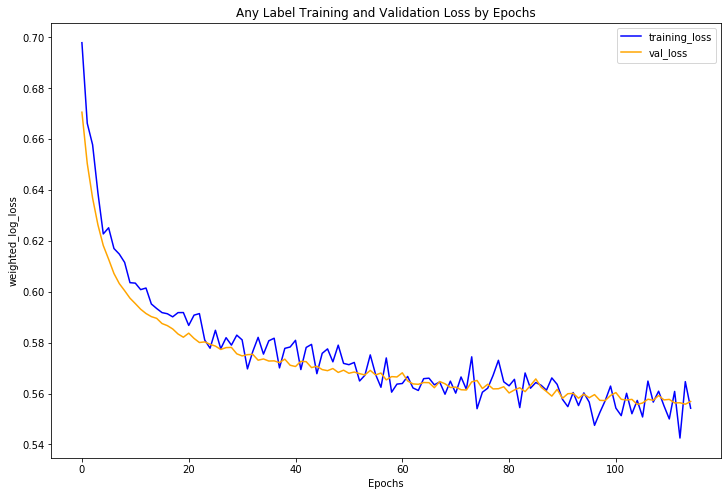

In [86]:
train_loss = model6_history.history['any_predictions_loss']
val_loss = model6_history.history['val_any_predictions_loss']

plt.figure(figsize = (12,8))

plt.plot(train_loss, label = 'training_loss', color = 'b')
plt.plot(val_loss, label = 'val_loss', color = 'orange')

plt.title('Any Label Training and Validation Loss by Epochs')
plt.xlabel('Epochs')
plt.ylabel('weighted_log_loss')
plt.legend();

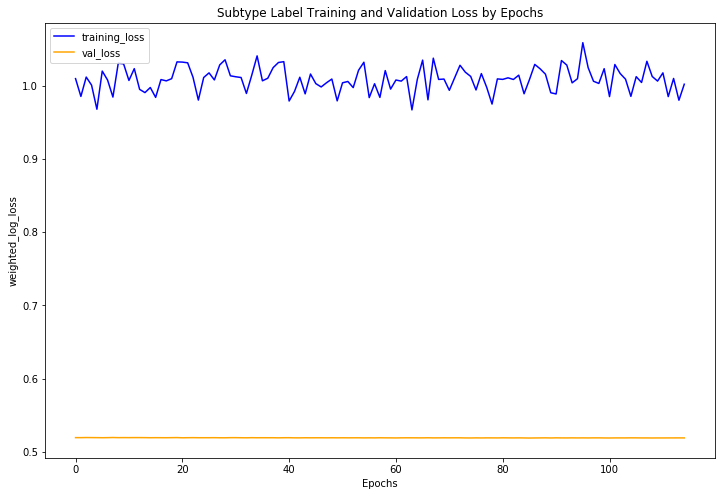

In [88]:
train_loss = model6_history.history['subtype_pred_loss']
val_loss = model6_history.history['val_subtype_pred_loss']

plt.figure(figsize = (12,8))

plt.plot(train_loss, label = 'training_loss', color = 'b')
plt.plot(val_loss, label = 'val_loss', color = 'orange')

plt.title('Subtype Label Training and Validation Loss by Epochs')
plt.xlabel('Epochs')
plt.ylabel('weighted_log_loss')
plt.legend();

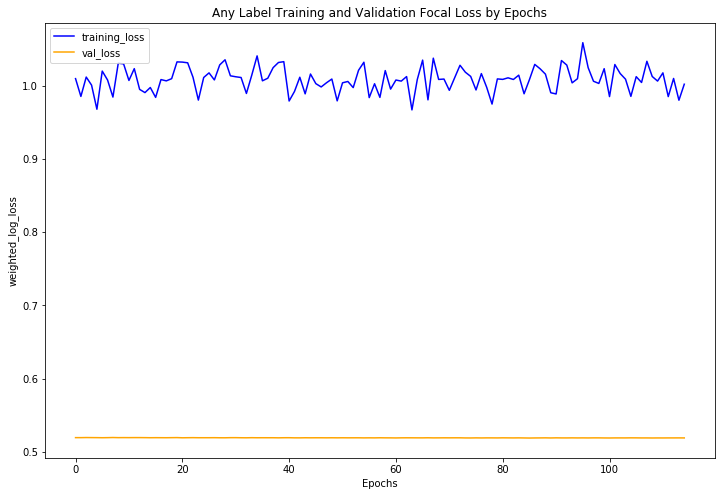

In [89]:
train_loss = model6_history.history['subtype_pred_focal_loss']
val_loss = model6_history.history['val_subtype_pred_focal_loss']

plt.figure(figsize = (12,8))

plt.plot(train_loss, label = 'training_loss', color = 'b')
plt.plot(val_loss, label = 'val_loss', color = 'orange')

plt.title('Any Label Training and Validation Focal Loss by Epochs')
plt.xlabel('Epochs')
plt.ylabel('weighted_log_loss')
plt.legend();

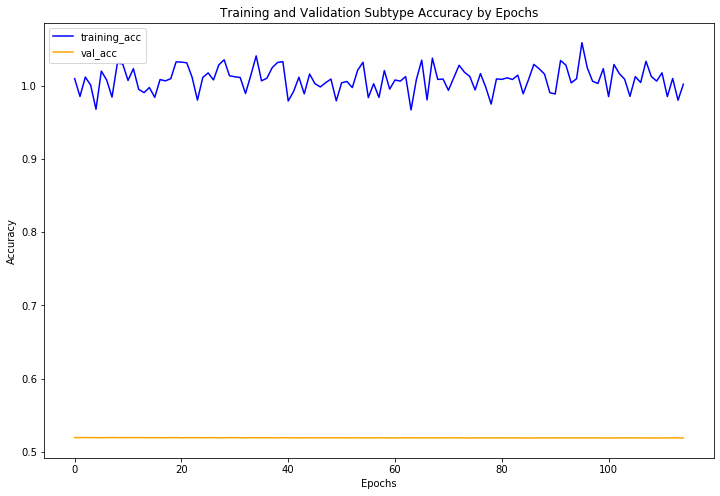

In [90]:
train_acc = model6_history.history['subtype_pred_accuracy']
val_acc = model6_history.history['val_subtype_pred_accuracy']

plt.figure(figsize = (12,8))

plt.plot(train_loss, label = 'training_acc', color = 'b')
plt.plot(val_loss, label = 'val_acc', color = 'orange')

plt.title('Training and Validation Subtype Accuracy by Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend();

In [91]:
train_proba_any, train_proba_subtype = model6.predict(data_generator_test)

In [92]:
train_proba_any.shape

(121232, 1)

In [93]:
train_proba_subtype.shape

(121232, 5)

In [94]:
submission = np.concatenate((train_proba_any,train_proba_subtype),axis=1)

In [95]:
submission.shape

(121232, 6)

In [96]:
def make_df(meta_data_df, predictions):
    df = pd.DataFrame(predictions, columns=meta_data_df.columns, index=meta_data_df.index)
    df = df.stack().reset_index()
    df.loc[:, "ID"] = df.id.str.cat(df.subtype, sep="_")
    df = df.drop(["id", "subtype"], axis=1)
    df = df.rename({0: "Label"}, axis=1)
    df = df[['ID','Label']]
   
    return df

In [97]:
submission_6 = make_df(test_df, submission)

In [98]:
submission_6.to_csv('../data/output/submissions/submission_model_6.csv', index=False)